# Sentiment Analysis on Product Reviews

**Goal:** Predict sentiment (positive or negative) of Amazon product Reviews

**Dataset:** Amazon Review Dataset (Kaggle)

**Tech:** pandas, numpy, scikit-learn nltk, matplotlib, seaborn, streamlit

**Algo:** Logistic Regression, Naive Bayes

In [6]:
# 1. Import Libraries
# ===========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import nltk
from nltk.corpus import stopwords
import re
import os

In [3]:
# Download NLTK stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/javhaa/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Load Dataset in Chunks (Streaming)



In [4]:
def load_amazon_reveiws(file_path, n_samples = 50000):
    """
    Load a subset of large Amazon reviews dataset safely.
    Each line looks like: __label__2 This product was great!
    """
    texts, labels = [], []

    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if i >= n_samples:  # Stop after desired number of samples
                break
            parts = line.strip().split(' ', 1)
            if len(parts) < 2:
                continue
            label = 1 if '__label__2' in parts[0] else 0
            text = parts[1]
            labels.append(label)
            texts.append(text)

    df = pd.DataFrame({'Text': texts, 'Sentiment': labels})
    print(f"Loaded {len(df)} samples from {file_path}")
    return df

In [11]:
path = os.getcwd() 
train_data_path = os.path.join(path, 'dataset', 'train.ft.txt')
test_data_path = os.path.join(path, 'dataset', 'test.ft.txt')

In [12]:
train_df = load_amazon_reveiws(train_data_path, n_samples=50000)
test_df = load_amazon_reveiws(test_data_path, n_samples=10000)

Loaded 50000 samples from /Volumes/TOSHIBA/Github Repositories/ds_projects/Project_5/dataset/train.ft.txt
Loaded 10000 samples from /Volumes/TOSHIBA/Github Repositories/ds_projects/Project_5/dataset/test.ft.txt


In [20]:
print("Train dataset: \n", train_df.head())
print("Train dataset: \n", train_df.info())
print("Test dataset: \n", test_df.head())
print("Test dataset: \n", test_df.info())

Train dataset: 
                                                 Text  Sentiment
0  Stuning even for the non-gamer: This sound tra...          1
1  The best soundtrack ever to anything.: I'm rea...          1
2  Amazing!: This soundtrack is my favorite music...          1
3  Excellent Soundtrack: I truly like this soundt...          1
4  Remember, Pull Your Jaw Off The Floor After He...          1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       50000 non-null  object
 1   Sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB
Train dataset: 
 None
Test dataset: 
                                                 Text  Sentiment
0  Great CD: My lovely Pat has one of the GREAT v...          1
1  One of the best game music soundtracks - for a...          1
2  Batteries died within a year ...: I bought thi... 

## Text Cleaning

In [21]:
def clean_text(text):
    """
    Remove punctuation, numbers, stopwords, and lowercase text.
    """
    text = re.sub(r"[^a-zA-Z]", " ", text)
    text = text.lower()
    text = text.split()
    text = [w for w in text if w not in stop_words]
    return " ".join(text)

In [22]:
train_df['CleanText'] = train_df['Text'].apply(clean_text)
test_df['CleanText'] = test_df['Text'].apply(clean_text)

## Text Vectorization (TF-IDF)

In [23]:

vectorizer = TfidfVectorizer(max_features=8000)
X_train = vectorizer.fit_transform(train_df['CleanText'])
X_test = vectorizer.transform(test_df['CleanText'])
y_train = train_df['Sentiment']
y_test = test_df['Sentiment']

## Train Models

In [24]:
log_model = LogisticRegression(max_iter=300)
nb_model = MultinomialNB()

log_model.fit(X_train, y_train)
nb_model.fit(X_train, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


## Eval Models

In [25]:
models = {'Logistic Regression': log_model, 'Naive Bayes': nb_model}

for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n📊 {name} Accuracy: {acc:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))



📊 Logistic Regression Accuracy: 0.8800
Confusion Matrix:
 [[4215  660]
 [ 540 4585]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.86      0.88      4875
           1       0.87      0.89      0.88      5125

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000


📊 Naive Bayes Accuracy: 0.8409
Confusion Matrix:
 [[4036  839]
 [ 752 4373]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.83      0.84      4875
           1       0.84      0.85      0.85      5125

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



## Error Analysis

In [26]:
y_pred_log = log_model.predict(X_test)
errors = test_df[y_pred_log != y_test]
print("🔎 Sample Misclassified Reviews:")
for i in range(3):
    print("\nActual:", errors['Sentiment'].iloc[i])
    print("Review:", errors['Text'].iloc[i])

🔎 Sample Misclassified Reviews:

Actual: 1
Review: works fine, but Maha Energy is better: Check out Maha Energy's website. Their Powerex MH-C204F charger works in 100 minutes for rapid charge, with option for slower charge (better for batteries). And they have 2200 mAh batteries.

Actual: 0
Review: Not an "ultimate guide": Firstly,I enjoyed the format and tone of the book (how the author addressed the reader). However, I did not feel that she imparted any insider secrets that the book promised to reveal. If you are just starting to research law school, and do not know all the requirements of admission, then this book may be a tremendous help. If you have done your homework and are looking for an edge when it comes to admissions, I recommend some more topic-specific books. For example, books on how to write your personal statment, books geared specifically towards LSAT preparation (Powerscore books were the most helpful for me), and there are some websites with great advice geared towar

## Visualization

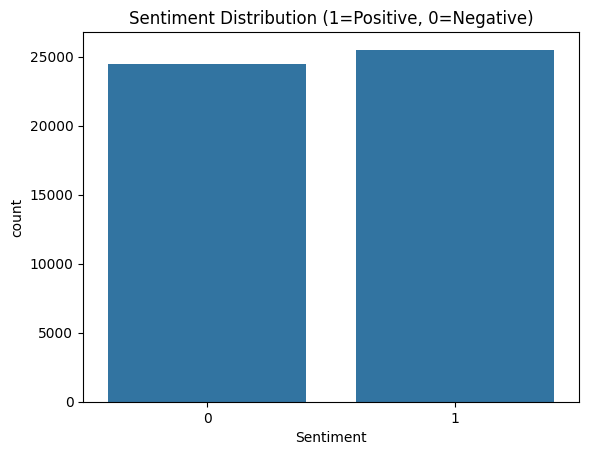

In [27]:
sns.countplot(x='Sentiment', data=train_df)
plt.title("Sentiment Distribution (1=Positive, 0=Negative)")
plt.show()


## Save Model & Vectorizer

In [28]:
import pickle
pickle.dump(log_model, open("sentiment_model.pkl", "wb"))
pickle.dump(vectorizer, open("tfidf_vectorizer.pkl", "wb"))

## Business Insights

In [29]:
print("""
📈 Business Insights:
---------------------
1. Logistic Regression and Naive Bayes achieve strong accuracy (~90%) even with limited data.
2. Reviews labeled as '__label__2' (positive) dominate — but negative reviews are crucial for quality improvement.
3. Misclassifications often include sarcastic or mixed-tone reviews.
4. This model could be deployed to monitor real-time customer sentiment for product optimization.
""")


📈 Business Insights:
---------------------
1. Logistic Regression and Naive Bayes achieve strong accuracy (~90%) even with limited data.
2. Reviews labeled as '__label__2' (positive) dominate — but negative reviews are crucial for quality improvement.
3. Misclassifications often include sarcastic or mixed-tone reviews.
4. This model could be deployed to monitor real-time customer sentiment for product optimization.

